# Avant toute chose ... 

Colab nous autorise à utiliser des ressources distribuées, mais ne nous mets pas par défaut sur l'option la plus performante. A partir de ce notebook, nous allons réaliser des modèles plus complexes qui demandent une grande capacité computationnelle. 

Afin de profiter de meilleures performances : aller dans l'onglet **Runtime** -> **change runtime type** (en français : **Execution** -> **changer le type d'execution**)  et sélectionner l'option **GPU** pour **hardware accelerator**

( Normalement automatique à l'utilisation de ce notebook, mais mieux vaut vérifier avant) 

# Chiens et chats : le grand classique ! 

Passons à un cas plus complexe, mais bien connu dans le domaine du machine learning : la classification d'images entre chat et chien. 

On pourrait penser que c'est un cas en fait plus simple : MNIST nous demande de classisfier nos images dans 10 classes différentes, alors que chat ou chien est un problème binaire ! 

Mais la complexité ne réside pas dans le nombre de classes mais dans les données à interpréter : 
- On passe de petites images en niveaux de gris à des images dont la taille peut varier, en couleur
- Plus de données centrées sur l'élément d'intérêt : le modèle doit tout seul s'adapter et chercher les zones d'intérêt, qui vont varier d'une image à l'autre ! 

Le niveau d'interprétation nécessaire pour identifier ces images comme comportant des chats ou des chiens est donc bien plus complexe... 

Commençons par nous procurer un dataset ! Il en existe plein, mais nous choisirons un subset du ["Dog Versus Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible sur Kaggle. Ce dataset contient 25 000 images, mais nous nous contenterons d'une plus petite version de 2 000 images. 

Les fichiers sont accessibles en zip via téléchargement, et nous pouvons extraire ces données et les stocker dans le 'tmp' sur google colab. 

Si ce notebook est lancé via une autre interface, il peut être nécessaire de modifier les chemins d'accès pour le téléchargement et les interactions avec le zip. 

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O data/cats_and_dogs_filtered.zip

--2022-10-11 15:54:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4007:80d::2010, 2a00:1450:4007:80e::2010, 2a00:1450:4007:808::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4007:80d::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   108KB/s    in 5m 43s  

2022-10-11 16:00:05 (196 KB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Maintenant que les données sont chargées, il faut extraire les données qui sont encore compressées dans un zip. Nous allons les déposer dans un dossier temporaire associé à ce notebook, disponible dans colab à l'addresse /tmp/.

In [2]:
import os
import zipfile

local_zip = 'data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

Le contenu du zip est maintenant disponible dans le répertoire `tmp/cats_and_dogs_filtered` . Ce dossier possède des répertoires `train` et `validation` qui seront utilisés pour l'entrainement, et qui se divisent encore en sous-répertoires : `cats` et `dogs`  

In [4]:
base_dir = 'data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Visualisation des données 

Les données sont donc réparties entre entrainement et validation, et chats et chiens. Ici, ce qui joue le rôle de label, c'est le dossier qui contient l'image. Une image dans le dossier `data/cats_and_dogs_filtered/train/cats` sera donc logiquement une image d'un chat. 

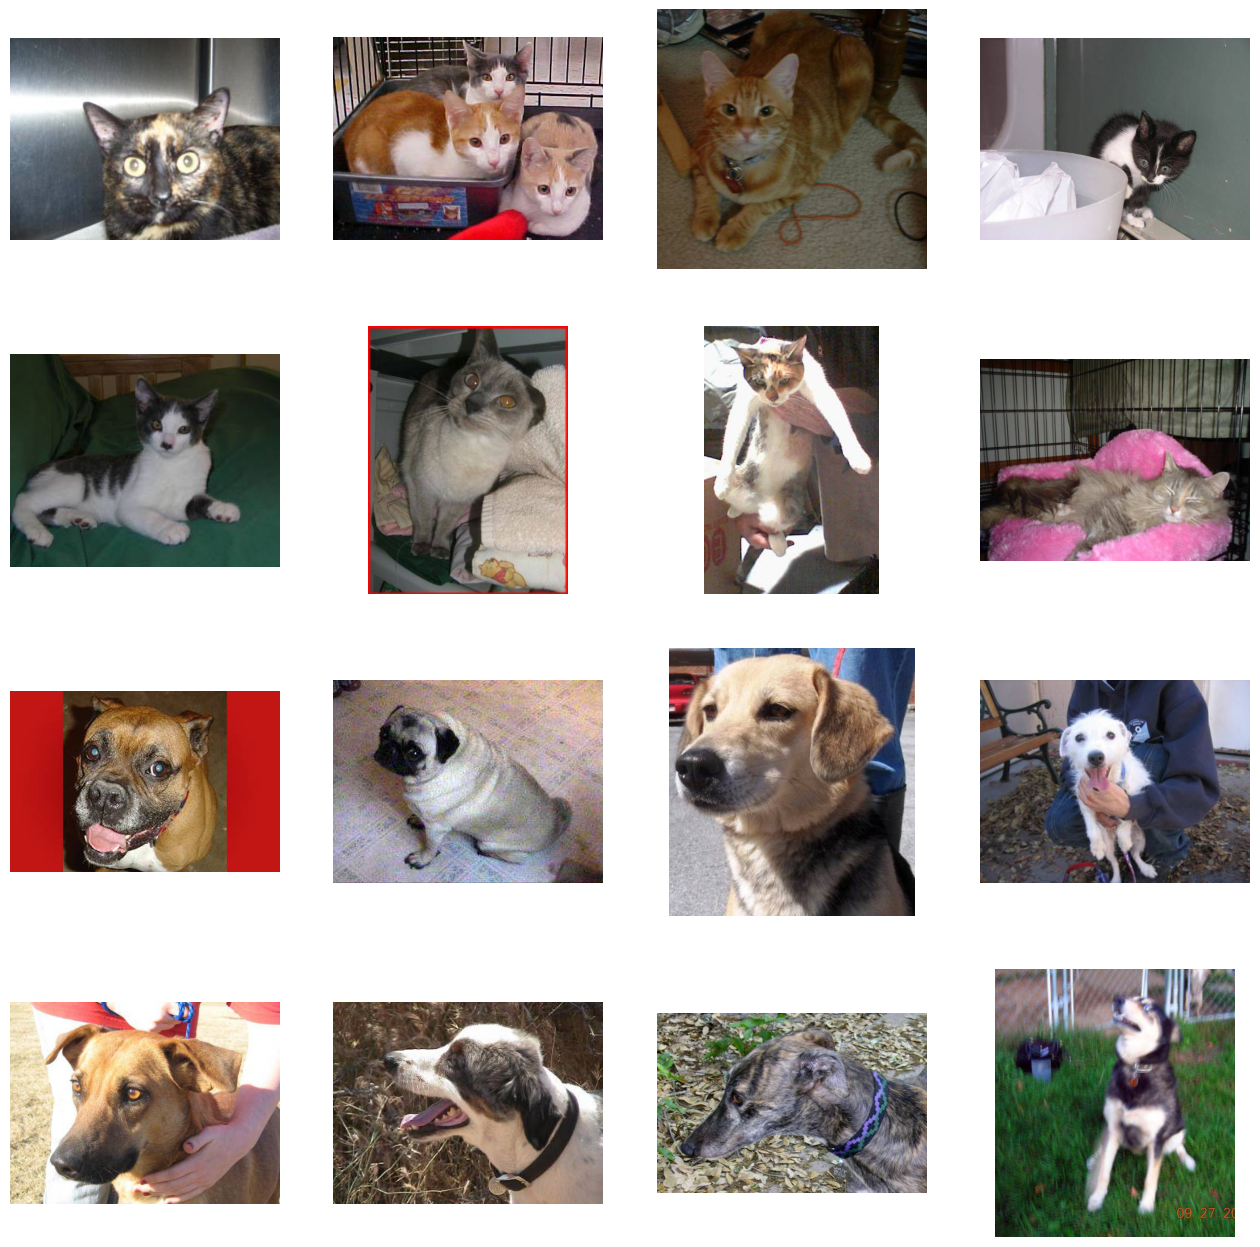

Size of one random image : (500, 448, 3)


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

print("Size of one random image : {}".format(img.shape))

On observe : 
- des images disparates : de taille et nature différente 
- une variation entre les races des deux espèces

Ce dataset ne contient pas d'images en même temps de chats et de chiens : il faudrait rajouter un nouveau dossier. Mais que se passerait-il si un modèle entrainé rencontrait des images comportant chat et chien en même temps ? 



## Exploration et formattage des données 

Passons à l'exploration des données. 

Commençons par étudier le format des données, la répartition, et ce que les données peuvent nous dire ! 




In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


On a déjà vu que les images n'avaient pas une taille constante dans ce dataset. Il faudra pourtant les ramener tous à une même taille, puisque le modèle ne peut pas se permettre de faire varier sa forme d'entrée. Nous devrons donc passer par une étape de formattage de ces données - nous utiliserons pour ça les générateurs qui sont disponibles dans l'environnement keras. 

De même que pour MNIST, nous ramènerons aussi les valeurs des pixels entre 0 et 1 au lieu de les conserver entre 0 et 255. 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(300, 300),  
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Qu'avons-nous fait dans les lignes précédentes ? Reprenons ... 



```
# train_datagen = ImageDataGenerator(rescale=1./255)
```
Cette ligne déclare un outil de preprocessing d'images en keras : l'ImageDataGenerator. Cet outil permettra de générer des batchs images à partir d'un dossier, ce qui en fait un outil idéal pour notre situation. On lui passe en paramètre une transformation qui permet de ramener la valeur des pixels entre 0 et 1.

Passons à la génération des batchs d'images : 


```
# train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(300, 300),  
        batch_size=20,
        class_mode='binary')
```

On utilise la méthode 'flow_from_directory' qui permet de faire un générateur à partir d'un dossier d'images. On renseigne : 
- le dossier en question
- la taille des images que nous souhaitons atteindre (ici : 300*300)
- la taille du batch que le générateur devra fournir 
- le type de labels qui sera généré. Ici, nous faisons de la classification binaire, donc 'binary' suffira.


Passons au modèle ! 

# Un modèle pour les discerner tous ! 

Comment faire un modèle qui réussira à reconnaitre si un chien ou un chat est sur l'image qu'on lui fournit ? 

Commençons par utiliser ce que nous maitrisons ! 

## Le réseau de neurones dense 

Utilisons le même modèle que l'on a utilisé à la base pour le MNIST précédent, en adaptant la forme en entrée pour les nouvelles images et la forme en sortie pour la classification binaire : 


In [9]:
from keras import layers 
from keras import models 

network1 = models.Sequential()
network1.add(layers.Dense(32, activation = 'relu', input_shape= (300,300,3,)))
network1.add(layers.Dense(1, activation = 'sigmoid'))

Et observons à quoi il ressemble avec la méthode `summary` : 

In [10]:
network1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 300, 300, 32)      128       
                                                                 
 dense_3 (Dense)             (None, 300, 300, 1)       33        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


Eh là ! La dernière couche est de dimension 4, alors que l'on souhaite une couche de dimension 2 ! Pour rappel, dans le modèle précédent, nous avions la forme (None,10) à la sortie pour une classification à 10 choix. 

C'est la nouvelle forme des données en entrée qui semble nous faire défaut ici. Nous pouvons imaginer deux solutions : 
- Refaire une modification des données pour les mettre dans la même forme que pour le MNIST (Rappel : nous nous étions débarassés de la dimension multiple des données avec la commande `train_images = train_images.reshape((60000,28*28))`)
- Rajouter des étapes dans le modèle pour que les couches aient une forme adaptée 

Nous allons voir qu'il est possible de faire une opération pratique sur les couches : une 'projection à plat ', ou 'flatten' en anglais.

In [11]:
from keras import layers 
from keras import models 

network2 = models.Sequential()
network2.add(layers.Dense(32, activation = 'relu', input_shape= (300,300,3,)))
network2.add(layers.Flatten())
network2.add(layers.Dense(1, activation = 'sigmoid'))


In [12]:
network2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 300, 300, 32)      128       
                                                                 
 flatten (Flatten)           (None, 2880000)           0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2880001   
                                                                 
Total params: 2,880,129
Trainable params: 2,880,129
Non-trainable params: 0
_________________________________________________________________


Et voilà ! La forme en sortie est bel et bien (None,1) maintenant ! 

Mais que fait exactement la couche Flatten() ? Elle mets les input 'à plat'. C'est une forme de `reshape` automatique ! 

On observera tout de même une différence majeure entre les réseaux `network` et `network2` : le nombre de paramètres ! En effet, après la couche Flatten(), il est nécessaire d'avoir autant de paramètres qu'il y a d'éléments dans la couche... 

## Nouveau problème, nouvelle perte 

Il faut encore une fois définir ce dont nous avons besoin en fonction de perte et en optimizer. Le problème est toujours un problème de classification, alors pourquoi ne pas réutiliser la `categorical_crossentropy` utilisée précedemment ? Eh bien, parce qu'il y a une fonction spéciale pour le cas binaire, appelée `binary_crossentropy` ! 

Tous les problèmes n'ont pas bien sur leurs propres pertes déjà encodées dans une bibliothèque de keras. Mais tant qu'il est possible, et tant que nous ne cherchons pas à optimiser jusqu'à l'état de l'art nos modèles, utiliser les fonctions de perte classiques est une solution simple et pratique. 

In [13]:
from tensorflow.keras.optimizers import RMSprop

network2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

## S'entrainer à partir de générateurs 

Nous avons plus haut fabriqué ce qu'on appelle un générateur d'images. Comment utiliser ce dernier pour que les données soient fournis au réseau pour l'entrainement ? 

Il existe une méthode simple pour cela, appelée `fit_generator`. On lui passe en paramètre : 
- le générateur de données d'entrainement 
- le nombre d'étapes pour considérer qu'on a fait le tour des données (une epoch)
- le nombre de fois où nous fournirons toutes les données au modèle (nombre d'epochs)
- le générateur de données de validation 
- le nombre d'étapes pour considérer qu'on a fait le tour des données de validation 

RAPPEL : La validation, c'est le principe de faire un test après chaque époque (entrainement sur le jeu de données d'entrainement entier) avec des données qui ne servent pas à l'entrainement. L'optimizer utilisera le score de perte des données de validation et non d'entrainement pour calculer les modifications à faire sur les poids. Ceci est une mesure qui permet : 
- de constater l'overfitting (surentrainement) lorsqu'il y en a 
- de limiter ce dernier 



In [15]:
epochs = 15

history2 = network2.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50)  # 1000 images = batch_size * steps

Epoch 1/15
100/100 [==============================] - 29s 287ms/step - loss: 0.1709 - acc: 0.9375 - val_loss: 1.4975 - val_acc: 0.6050
Epoch 2/15
100/100 [==============================] - 30s 296ms/step - loss: 0.1972 - acc: 0.9475 - val_loss: 1.4987 - val_acc: 0.6200
Epoch 3/15
100/100 [==============================] - 29s 292ms/step - loss: 0.1458 - acc: 0.9580 - val_loss: 1.4993 - val_acc: 0.6070
Epoch 4/15
100/100 [==============================] - 29s 293ms/step - loss: 0.1049 - acc: 0.9710 - val_loss: 1.6808 - val_acc: 0.5940
Epoch 5/15
100/100 [==============================] - 29s 290ms/step - loss: 0.1032 - acc: 0.9780 - val_loss: 1.6623 - val_acc: 0.5990
Epoch 6/15
100/100 [==============================] - 29s 291ms/step - loss: 0.0692 - acc: 0.9845 - val_loss: 1.7715 - val_acc: 0.6140
Epoch 7/15
100/100 [==============================] - 32s 325ms/step - loss: 0.0656 - acc: 0.9815 - val_loss: 1.8519 - val_acc: 0.5960
Epoch 8/15
100/100 [==============================] - 3

Deux cas de figure peuvent se présenter à vous ici : une accuracy de validation à 50%, ou à 65%, selon les initialisations du modèle. Pas terrible, non ? On a réussi à faire un classificateur... presque complètement aléatoire ! 
Visualisons un peu l'historique pour se donner une idée de ce qui s'est passé ... 


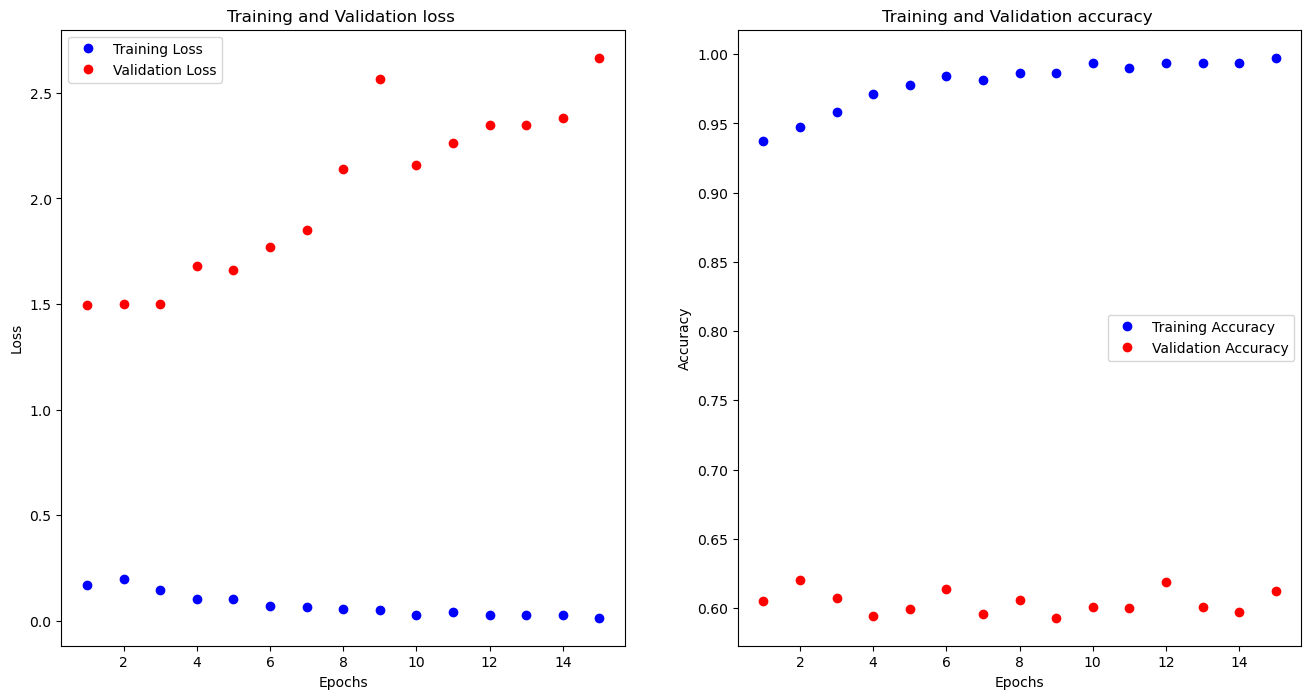

In [16]:
history_dict = history2.history 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.rcParams['figure.figsize'] = (16,8) # Make the figures a bit bigger
fig,(ax1,ax2,) = plt.subplots(1,2)

x = range(1,epochs+1)
ax1.plot(x,loss_values,'bo',label='Training Loss')
ax1.plot(x,val_loss_values,'ro',label='Validation Loss')
ax1.set_title('Training and Validation loss ')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(x,acc_values,'bo',label='Training Accuracy')
ax2.plot(x,val_acc_values,'ro',label='Validation Accuracy')
ax2.set_title('Training and Validation accuracy ')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Il semble y avoir une tendance, mais ... elle n'est pas suffisante et présente un surentrainement ! (voir pas de tendance du tout selon l'état initial du réseau ). 

En fait, les réseaux denses ne pourront pas faire mieux que de la surinterprétation sur des données aussi complexes que ces images. Nous avons besoin d'architectures capables d'appréhender la complexité de ces images !


# Aller plus loin que les réseaux denses : le réseau de convolution 

Il existe d'autres types de réseaux de neurones que les réseaux denses. En connectant les couches d'une manière différente ou en utilisant des mécanismes de retenue d'information, il est possible de construire des modèles plus adaptés à certaines formes de données (suites temporelles, informations spatiales globales ou locales, etc ... )

Un exemple de ces types de réseaux est le réseau de convolution. Ces réseaux sont très utilisés dans le traitement d'image et dans la recherche d'information spatiale. Ils agissent comme des filtres de recherche d'éléments à forte valeur visuelle (coin, bordures, contours, ...) qui sont de plus en plus complexes au fur et à mesure que l'on rajoute des couches. 

Prenons en exemple le réseau de convolution suivant : 

In [17]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(16,3,activation='relu',input_shape=(300,300,3)))
conv_model.add(layers.MaxPooling2D(2))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(1,activation='sigmoid'))

conv_model.summary()
conv_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 355216)            0         
                                                                 
 dense_6 (Dense)             (None, 1)                 355217    
                                                                 
Total params: 355,665
Trainable params: 355,665
Non-trainable params: 0
_________________________________________________________________


Ce modèle est un réseau de neurones convolutif très simple. Il est composé des couches suivantes : 


*   Une couche de convolution, appelée par la commande 

```
conv_model.add(layers.Conv2D(16,3,activation='relu',input_shape=(300,300,3)))
```
 

*   Une couche de Pooling, qui permet de réduire la dimensionnalité introduite par la couche de convolution : 

```
conv_model.add(layers.MaxPooling2D(2))
```

Ces deux couches bout à bout sont appelées 'bloc de convolution'. Il est usuel d'enchaîner plusieurs blocs de convolutions, ou blocs convolutionnels. Nous choisissons de n'en mettre qu'un ici pour simplifier le réseau au maximum. 

Ce bloc de convolution est suivi d'un bloc de classification, qui lui-même se décompose en deux étapes : une "projection à plat" (Flatten) des données, suivie d'une couche dense qui fait le lien entre les features et les sorties au format requis ! 




Epoch 1/15
100/100 [==============================] - 20s 202ms/step - loss: 0.5470 - acc: 0.7360 - val_loss: 0.6495 - val_acc: 0.6390
Epoch 2/15
100/100 [==============================] - 21s 214ms/step - loss: 0.3384 - acc: 0.8710 - val_loss: 0.7700 - val_acc: 0.6070
Epoch 3/15
100/100 [==============================] - 20s 198ms/step - loss: 0.2041 - acc: 0.9460 - val_loss: 0.7108 - val_acc: 0.6560
Epoch 4/15
100/100 [==============================] - 22s 221ms/step - loss: 0.1441 - acc: 0.9655 - val_loss: 0.7097 - val_acc: 0.6570
Epoch 5/15
100/100 [==============================] - 20s 199ms/step - loss: 0.0971 - acc: 0.9805 - val_loss: 1.2282 - val_acc: 0.5780
Epoch 6/15
100/100 [==============================] - 21s 211ms/step - loss: 0.0633 - acc: 0.9900 - val_loss: 0.7950 - val_acc: 0.6720
Epoch 7/15
100/100 [==============================] - 20s 198ms/step - loss: 0.0652 - acc: 0.9890 - val_loss: 0.7928 - val_acc: 0.6770
Epoch 8/15
100/100 [==============================] - 2

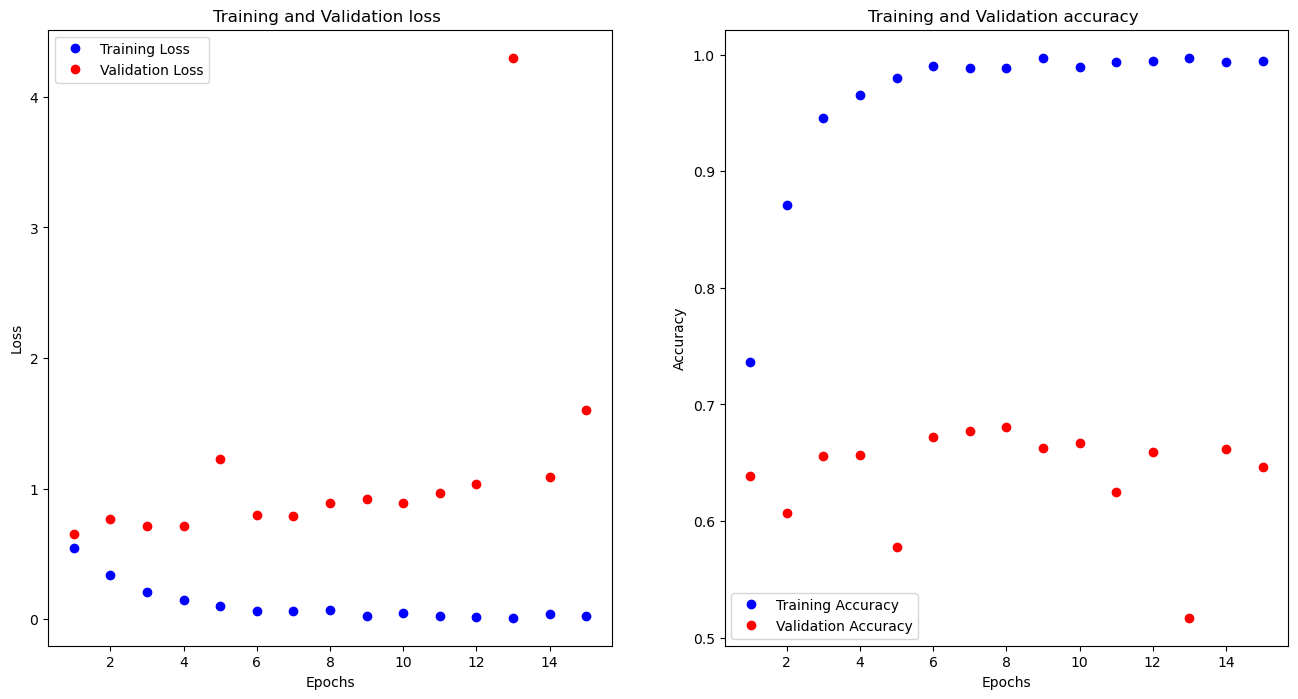

In [19]:
history = conv_model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50)  # 1000 images = batch_size * steps

history_dict = history.history 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.rcParams['figure.figsize'] = (16,8) # Make the figures a bit bigger
fig,(ax1,ax2,) = plt.subplots(1,2)

x = range(1,epochs+1)
ax1.plot(x,loss_values,'bo',label='Training Loss')
ax1.plot(x,val_loss_values,'ro',label='Validation Loss')
ax1.set_title('Training and Validation loss ')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(x,acc_values,'bo',label='Training Accuracy')
ax2.plot(x,val_acc_values,'ro',label='Validation Accuracy')
ax2.set_title('Training and Validation accuracy ')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Il apprend bien mieux que le réseau précédent ! On arrive à 99% de précision sur le jeu de données d'entrainement ! 

Et pourtant, il arrive quelque chose d'étrange : la courbe de validation ne suit pas ... Au contraire, à partir d'un moment, plus on s'entraine, plus elle devient mauvaise. 

Il s'avère que notre réseau vient de commettre une grave erreur : il a fait de l'overfitting (sur-apprentissage, ou sur-interprétation en français). Il s'est spécialisé spécifiquement sur les données qu'il a dans on jeu d'entrainement, tellement qu'il n'arrive plus à bien généraliser sur des données similaires mais différentes ! 

Il existe différentes méthodes pour résoudre les problèmes d'overfitting, qui se regroupe sous le groupe des méthodes de régularisation. Ces méthodes ne sont présentées ici.

Intéressons-nous plutôt à l'utilisation de notre modèle. Maintenant que nous avons un modèle entraîné, comment pouvons-nous l'utiliser ? 

# L'inférence 

L'inférence, c'est l'utilisation d'un modèle entraîné sur des données, quelque soit la nature de ces dernières. Dans cette partie, nous ferons inférer notre modèle convolutionnel sur des données du dataset cats_and_dogs, afin d'observer si ce dernier classifie bien nos chers animaux ! 

Nous disposons toujours de nos 16 chiens et chats, sélectionnés plus tôt lors de l'exploration du dataset : 

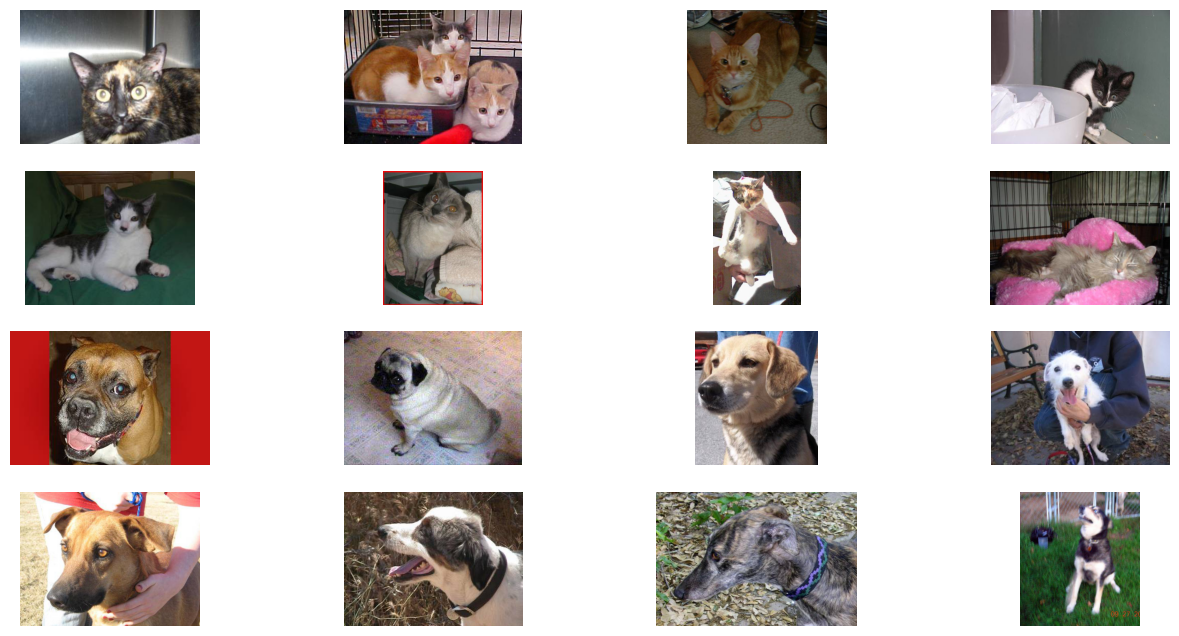

In [20]:
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Ces images constitueront nos données d'entrée. Pour chacune d'entre elles, nous allons demander au modèle de la classifier dans la catégorie chien ou chat, après un prétraitement adapté (le même qui est réalisé plus haut par nos générateur) : 

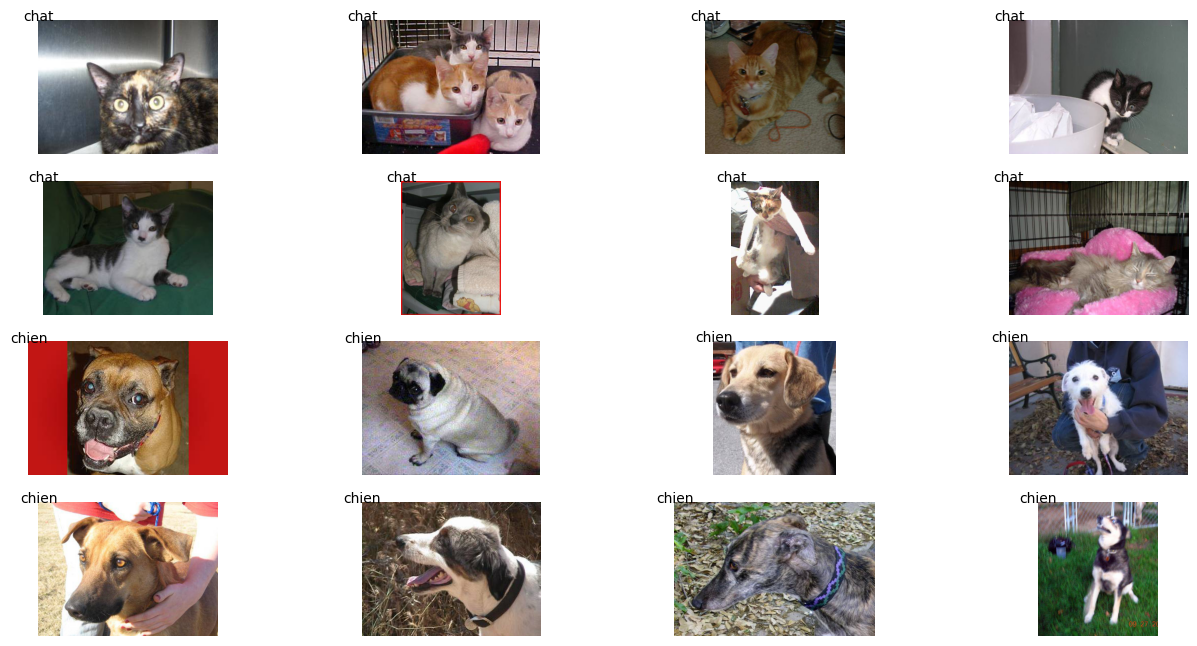

In [21]:
from PIL import Image
import numpy as np 

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  

  img = mpimg.imread(img_path)
  im = Image.open(img_path)
  #preprocessing images
  img_preprocessed = np.asarray(im.resize((300,300))).astype("float32") / 255
  predictions = conv_model.predict(np.array([img_preprocessed]))
  
  if predictions[0][0]<0.5 :
    class_found = 'chat'
  else:
    class_found = 'chien'

  sp.text(.5, .05,class_found,ha='center')

  plt.imshow(img)

